In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1)  # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

# Define GPU device - We will run our model on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
IMAGE_SIZE = 128  # Resize to 128x128 as per your model requirements
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

# Data transformations with augmentation for training, and normalization for testing
composed_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize image to 128x128
    transforms.RandomRotation(20),  # Randomly rotate some images by 20 degrees
    transforms.RandomHorizontalFlip(0.1),  # Randomly horizontally flip the images
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False)
])

composed_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize image to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
# Load CIFAR-10 dataset and apply the transformations
train_dataset = dsets.CIFAR10(root='./data', train=True, download=True, transform=composed_train)
validation_dataset = dsets.CIFAR10(root='./data', train=False, download=True, transform=composed_test)

100%|██████████| 170M/170M [00:30<00:00, 5.58MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Create data loaders for training and validation
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [ ]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
class CNN_V20(nn.Module):
    """
    A CNN architecture with 20 convolutional layers, pooling after every 2 convolutional layers.
    The input image size is 128x128 to accommodate all convolutional and pooling layers.
    """
    def __init__(self, number_of_classes=10, p=0.5):
        super(CNN_V20, self).__init__()

        # Convolution layers and pooling layers
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()

        in_channels = 3  # RGB images (3 channels)
        out_channels = 32  # Initial number of output channels

        # Build 20 convolutional layers (10 sets of 2 conv layers + pooling)
        for i in range(10):
            # First convolution block
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1))
            self.conv_layers.append(nn.BatchNorm2d(out_channels))
            self.conv_layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels  # Update input channels for next layer

            # Second convolution block
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1))
            self.conv_layers.append(nn.BatchNorm2d(out_channels))
            self.conv_layers.append(nn.ReLU(inplace=True))

            # After every two convolutions, add a max pooling layer
            if (i % 2 == 1):  # Apply pooling after every 2 convolutions
                self.pool_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Calculate the flattened size after convolutions and poolings
        # Input size: 128x128
        final_size = 128
        for _ in range(5):  # 5 pooling layers
            final_size = final_size // 2

        # Final flattened size is (number of channels) * (final spatial dimension)
        self.flattened_size = out_channels * final_size * final_size

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 1000)
        self.fc1_bn = nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc2_bn = nn.BatchNorm1d(1000)
        self.fc3 = nn.Linear(1000, number_of_classes)

        # Dropout layer
        self.drop = nn.Dropout(p=p)

    def forward(self, x):
        # Forward pass through convolutional layers
        for i in range(0, len(self.conv_layers), 3):
            x = self.conv_layers[i](x)  # Convolution layer
            x = self.conv_layers[i+1](x)  # BatchNorm
            x = self.conv_layers[i+2](x)  # ReLU activation

            # Every 2 convolutions followed by pooling
            if (i // 3) < len(self.pool_layers):
                x = self.pool_layers[i // 3](x)

        # Flatten the output from convolutions
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = torch.relu(x)
        x = self.drop(x)

        x = self.fc2(x)
        x = self.fc2_bn(x)
        x = torch.relu(x)
        x = self.drop(x)

        x = self.fc3(x)
        return x


In [ ]:
# Define training loop function
def train_model(model, train_loader, validation_loader, optimizer, criterion, n_epochs=20):
    # Global variable
    N_test = len(validation_dataset)
    accuracy_list = []
    train_loss_list = []
    val_loss_list = []
    model = model.to(device)

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_cost = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()

            train_cost += loss.item()

        train_cost = train_cost / len(train_loader)
        train_loss_list.append(train_cost)

        # Validation phase
        correct = 0
        model.eval()
        val_cost = 0
        for x_test, y_test in validation_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            z = model(x_test)
            val_loss = criterion(z, y_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            val_cost += val_loss.item()

        val_cost = val_cost / len(validation_loader)
        val_loss_list.append(val_cost)

        accuracy = correct / N_test
        accuracy_list.append(accuracy)

        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"Training Loss: {train_cost:.4f}, "
              f"Validation Loss: {val_cost:.4f}, "
              f"Validation Accuracy: {accuracy * 100:.2f}%")

    return accuracy_list, train_loss_list, val_loss_list

In [ ]:
# Initialize the model, optimizer, and loss function
model = CNN_V20(number_of_classes=10, p=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
accuracy, train_loss, val_loss = train_model(model, train_loader, validation_loader, optimizer, criterion, n_epochs=20)

Epoch 1/20, Training Loss: 1.7625, Validation Loss: 1.4261, Validation Accuracy: 47.35%
Epoch 2/20, Training Loss: 1.4123, Validation Loss: 1.3011, Validation Accuracy: 53.54%
Epoch 3/20, Training Loss: 1.2519, Validation Loss: 1.0857, Validation Accuracy: 60.41%
Epoch 4/20, Training Loss: 1.1398, Validation Loss: 1.0699, Validation Accuracy: 62.14%
Epoch 5/20, Training Loss: 1.0488, Validation Loss: 0.9844, Validation Accuracy: 65.71%
Epoch 6/20, Training Loss: 1.0024, Validation Loss: 0.9875, Validation Accuracy: 64.92%
Epoch 7/20, Training Loss: 0.9427, Validation Loss: 0.8972, Validation Accuracy: 69.14%
Epoch 8/20, Training Loss: 0.9068, Validation Loss: 0.9132, Validation Accuracy: 69.28%
Epoch 9/20, Training Loss: 0.8765, Validation Loss: 0.8605, Validation Accuracy: 70.92%
Epoch 10/20, Training Loss: 0.8586, Validation Loss: 0.7841, Validation Accuracy: 73.18%
Epoch 11/20, Training Loss: 0.8322, Validation Loss: 0.7789, Validation Accuracy: 73.51%
Epoch 12/20, Training Loss: 0.

In [ ]:
# Save the model
torch.save(model.state_dict(), 'cnn_v20_model.pth')

In [ ]:
def evaluate_model(model, validation_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for x_test, y_test in validation_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()

    accuracy = 100 * correct / total
    print(f"Final Accuracy on Test Set: {accuracy:.2f}%")
    return accuracy

# Call the function to print final accuracy
final_accuracy = evaluate_model(model, validation_loader, device)


Final Accuracy on Test Set: 76.83%


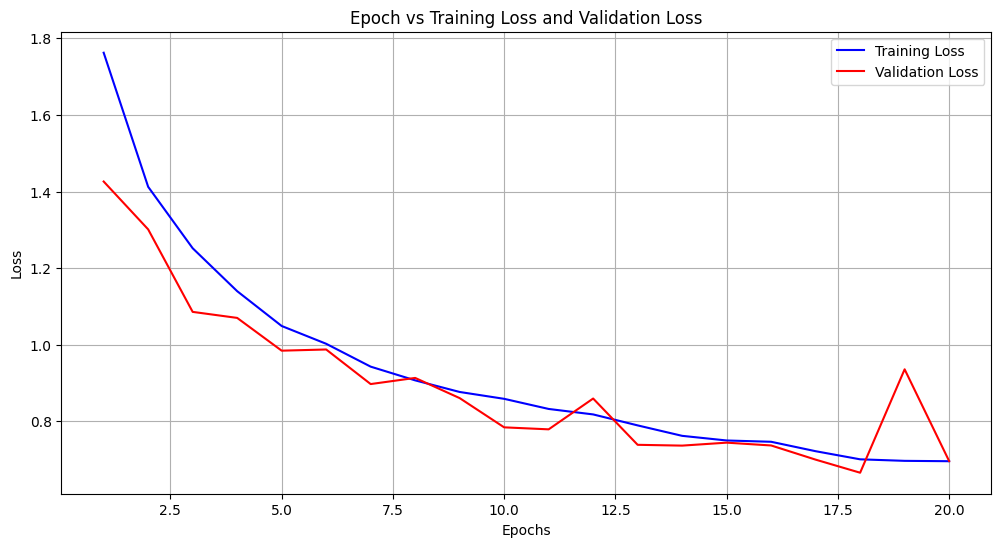

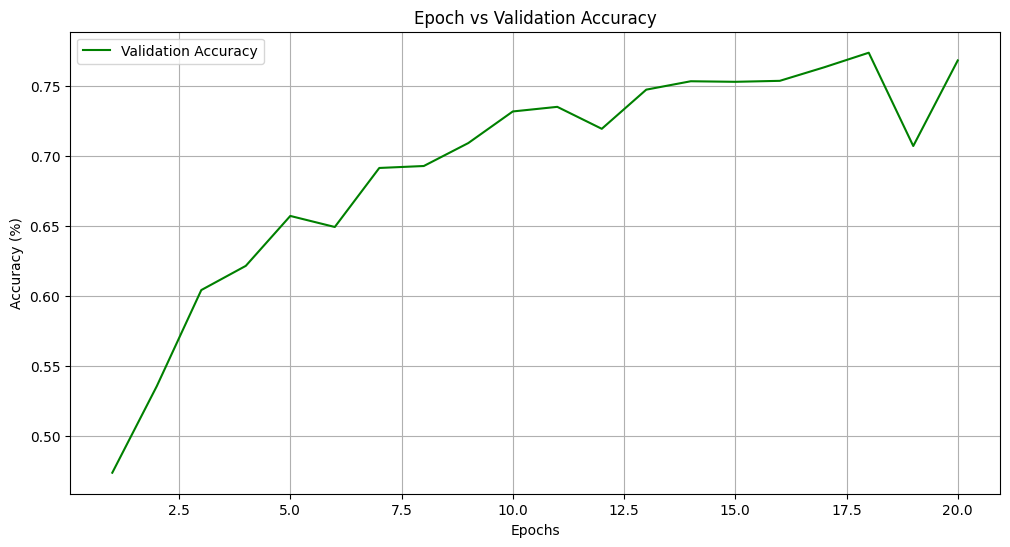

In [ ]:
import matplotlib.pyplot as plt

# Plotting Epoch vs Training Loss, Validation Loss and Validation Accuracy
epochs = range(1, len(train_loss) + 1)

# Plot for Training Loss and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='b')
plt.plot(epochs, val_loss, label='Validation Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Training Loss and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot for Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, label='Validation Accuracy', color='g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Epoch vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


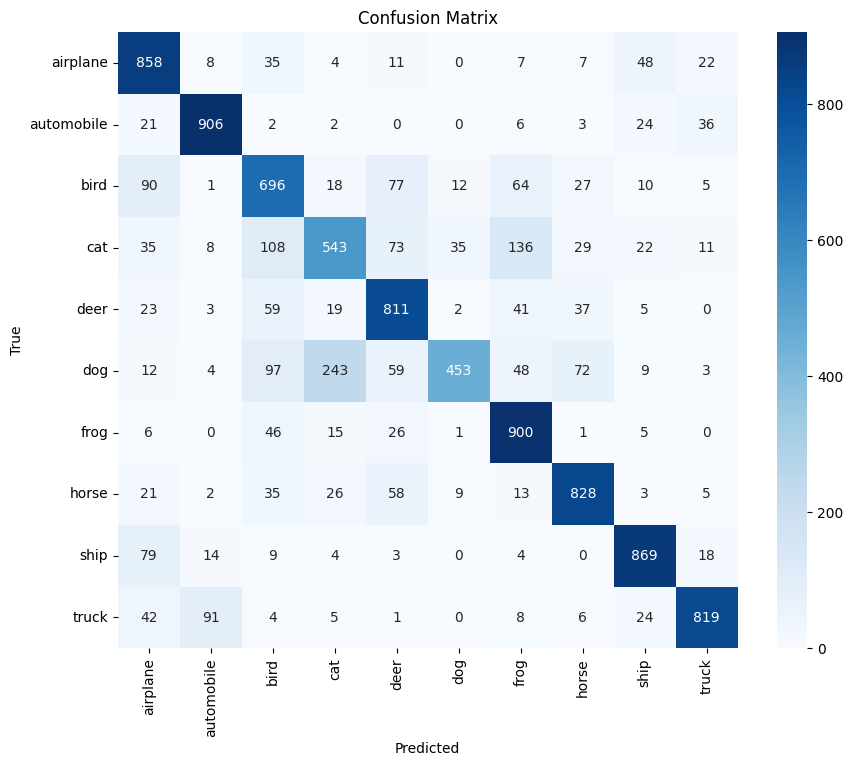

In [ ]:
import seaborn as sn
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, validation_loader, device, classes):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_test, y_test in validation_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(y_test.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    ax = sn.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plt.show()

# Call the function to plot confusion matrix
plot_confusion_matrix(model, validation_loader, device, classes)


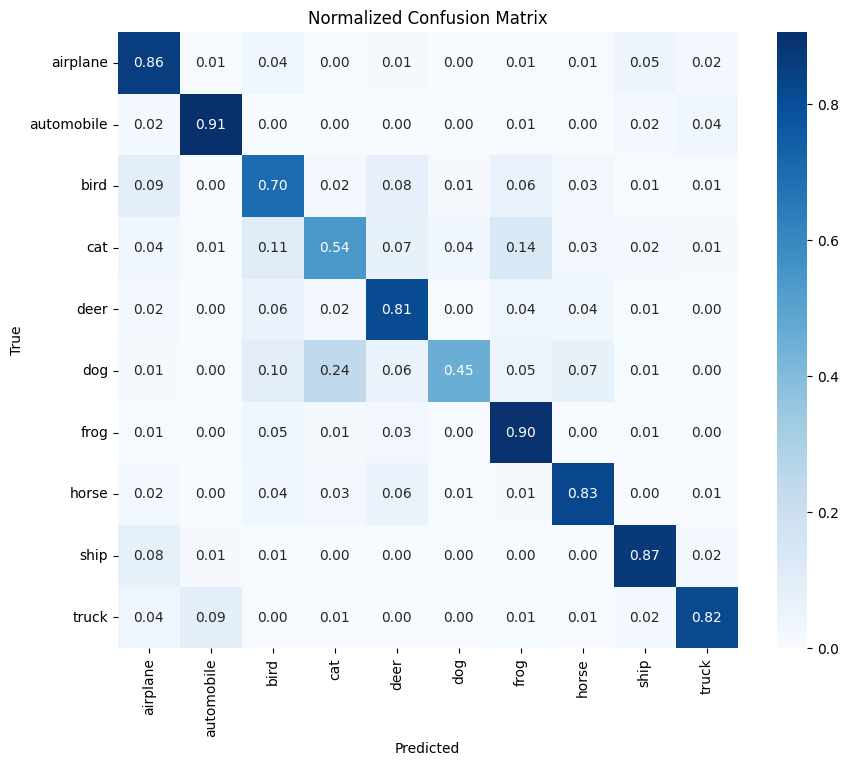

In [ ]:
def plot_normalized_confusion_matrix(model, validation_loader, device, classes):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_test, y_test in validation_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(y_test.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by dividing each row by its sum
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    ax = sn.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Normalized Confusion Matrix')
    plt.show()

# Call the function to plot normalized confusion matrix
plot_normalized_confusion_matrix(model, validation_loader, device, classes)

In [ ]:
from sklearn.metrics import classification_report

def plot_classification_report(model, validation_loader, device, classes):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_test, y_test in validation_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(y_test.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:")
    print(report)

# Call the function to print the classification report
plot_classification_report(model, validation_loader, device, classes)


Classification Report:
              precision    recall  f1-score   support

    airplane       0.72      0.86      0.78      1000
  automobile       0.87      0.91      0.89      1000
        bird       0.64      0.70      0.67      1000
         cat       0.62      0.54      0.58      1000
        deer       0.72      0.81      0.77      1000
         dog       0.88      0.45      0.60      1000
        frog       0.73      0.90      0.81      1000
       horse       0.82      0.83      0.82      1000
        ship       0.85      0.87      0.86      1000
       truck       0.89      0.82      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.76     10000
weighted avg       0.78      0.77      0.76     10000



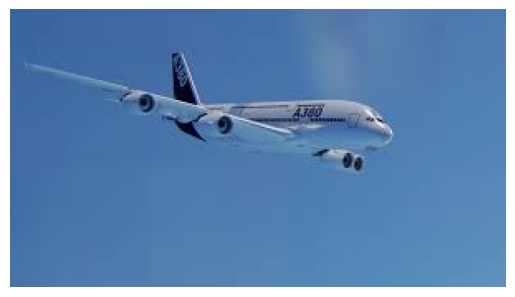

Predicted class: airplane


In [ ]:
import torch
import requests
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# URL of the image
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRsa3ISspmdRq4nDC9M6pfoNh1TvukFHBzGuA&usqp=CAU'

# Fetch image
response = requests.get(url, stream=True)
img = Image.open(response.raw)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Transformations: These should match the ones used during training
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image to 32x32
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean, std)  # Normalize the image with mean and std
])

# Ensure img is a PIL Image before applying the transformation
if isinstance(img, Image.Image):
    img_tensor = transform(img)  # Apply transformations
else:
    raise TypeError(f"Expected PIL image, got {type(img)}")

# Add batch dimension (1, 3, 32, 32)
img_tensor = img_tensor.unsqueeze(0)

# Check if a GPU is available, and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor = img_tensor.to(device)

# Assuming the model is loaded and on the correct device
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to compute gradients
    output = model(img_tensor)  # Forward pass through the model

# Get the predicted class
_, predicted_class = torch.max(output, 1)

# CIFAR-10 class names
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Display the predicted class
print(f'Predicted class: {classes[predicted_class.item()]}')

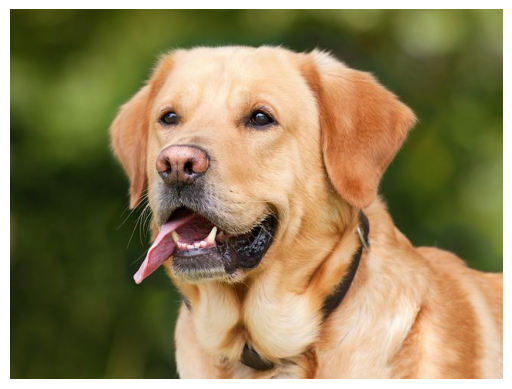

Predicted class: dog


In [ ]:
# URL of the image
url = 'https://cdn.pixabay.com/photo/2016/02/19/15/46/labrador-retriever-1210559__480.jpg'

# Fetch image
response = requests.get(url, stream=True)
img = Image.open(response.raw)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Transformations: These should match the ones used during training
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image to 32x32
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean, std)  # Normalize the image with mean and std
])

# Ensure img is a PIL Image before applying the transformation
if isinstance(img, Image.Image):
    img_tensor = transform(img)  # Apply transformations
else:
    raise TypeError(f"Expected PIL image, got {type(img)}")

# Add batch dimension (1, 3, 32, 32)
img_tensor = img_tensor.unsqueeze(0)

# Check if a GPU is available, and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor = img_tensor.to(device)

# Assuming the LeNet model is loaded and on the correct device
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to compute gradients
    output = model(img_tensor)  # Forward pass through the model

# Get the predicted class
_, predicted_class = torch.max(output, 1)

# CIFAR-10 class names
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Display the predicted class
print(f'Predicted class: {classes[predicted_class.item()]}')

Files already downloaded and verified


Predicted label: cat
Actual label: cat


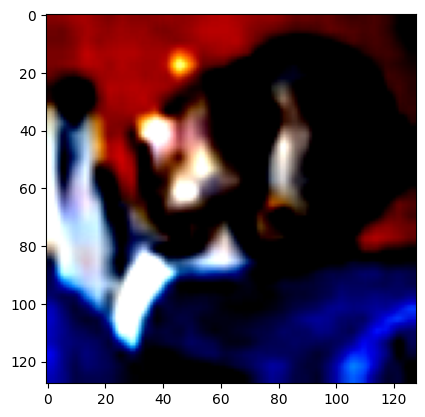

In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Define transformations for the test data (same as when training)
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match the input size of ResNet-18
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),  # CIFAR-10 normalization
])

# Load the CIFAR-10 test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Get a batch of images and labels
images, labels = next(iter(test_loader))

# Move the images and labels to the same device as the model
images = images.to(device)
labels = labels.to(device)

# Perform inference (prediction)
with torch.no_grad():  # We don't need gradients for inference
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Get class names from the dataset
class_names = test_dataset.classes

# Print the predicted and actual (true) labels
print("Predicted label:", class_names[predicted.item()])
print("Actual label:", class_names[labels.item()])

# Show the image
plt.imshow(images[0].cpu().numpy().transpose((1, 2, 0)))  # Convert from Tensor to Numpy for imshow
plt.show()

In [ ]:
!pip install torchsummary


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           9,248
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
        MaxPool2d-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           9,248
      BatchNorm2d-14           [-1, 32,

In [ ]:
# To load the model's state dictionary
# Step 1: Reinitialize the model architecture
loaded_model = CNN_V20(number_of_classes=10, p=0.5)

# Step 2: Load the saved state dictionary
# Provide the correct path to your model file.
# If it's in a different directory, specify the full path.
# For example, if it's in a folder named 'models':
loaded_model.load_state_dict(torch.load("models/cnn_v20_model.pth"))

# Step 3: Move the model to the same device it was trained on (if needed)
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode (if you're using it for inference)
loaded_model.eval()

<ipython-input-10-3645b248c81d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("models/cnn_v20_model.pth"))


FileNotFoundError: [Errno 2] No such file or directory: 'models/cnn_v20_model.pth'